
Récupération des données: BSS001ZEFE - LAC BLAGON (LANTON-33)
Code BSS: 08262X0290/F
Total de mesures disponibles: 6019
Page 1: +1000 mesures (total: 1000)
Page 2: +1000 mesures (total: 2000)
Page 3: +1000 mesures (total: 3000)
Page 4: +1000 mesures (total: 4000)
Page 5: +1000 mesures (total: 5000)
Page 6: +1000 mesures (total: 6000)
Page 7: +19 mesures (total: 6019)
✓ Récupération terminée: 6019 mesures

Récupération des données: BSS001ZDGR - PIRAILLAN (LEGE CAP FERRET-33)
Code BSS: 08257X0086/F
Total de mesures disponibles: 6510
Page 1: +1000 mesures (total: 1000)
Page 2: +1000 mesures (total: 2000)
Page 3: +1000 mesures (total: 3000)
Page 4: +1000 mesures (total: 4000)
Page 5: +1000 mesures (total: 5000)
Page 6: +1000 mesures (total: 6000)
Page 7: +510 mesures (total: 6510)
✓ Récupération terminée: 6510 mesures

CRÉATION DES GRAPHIQUES

BSS001ZEFE - LAC BLAGON (LANTON-33)
  Période: 28/04/2009 → 25/02/2026
  Durée: 6147 jours
  Profondeur min: 8.53 m
  Profondeur max: 11.86 m
  Pro

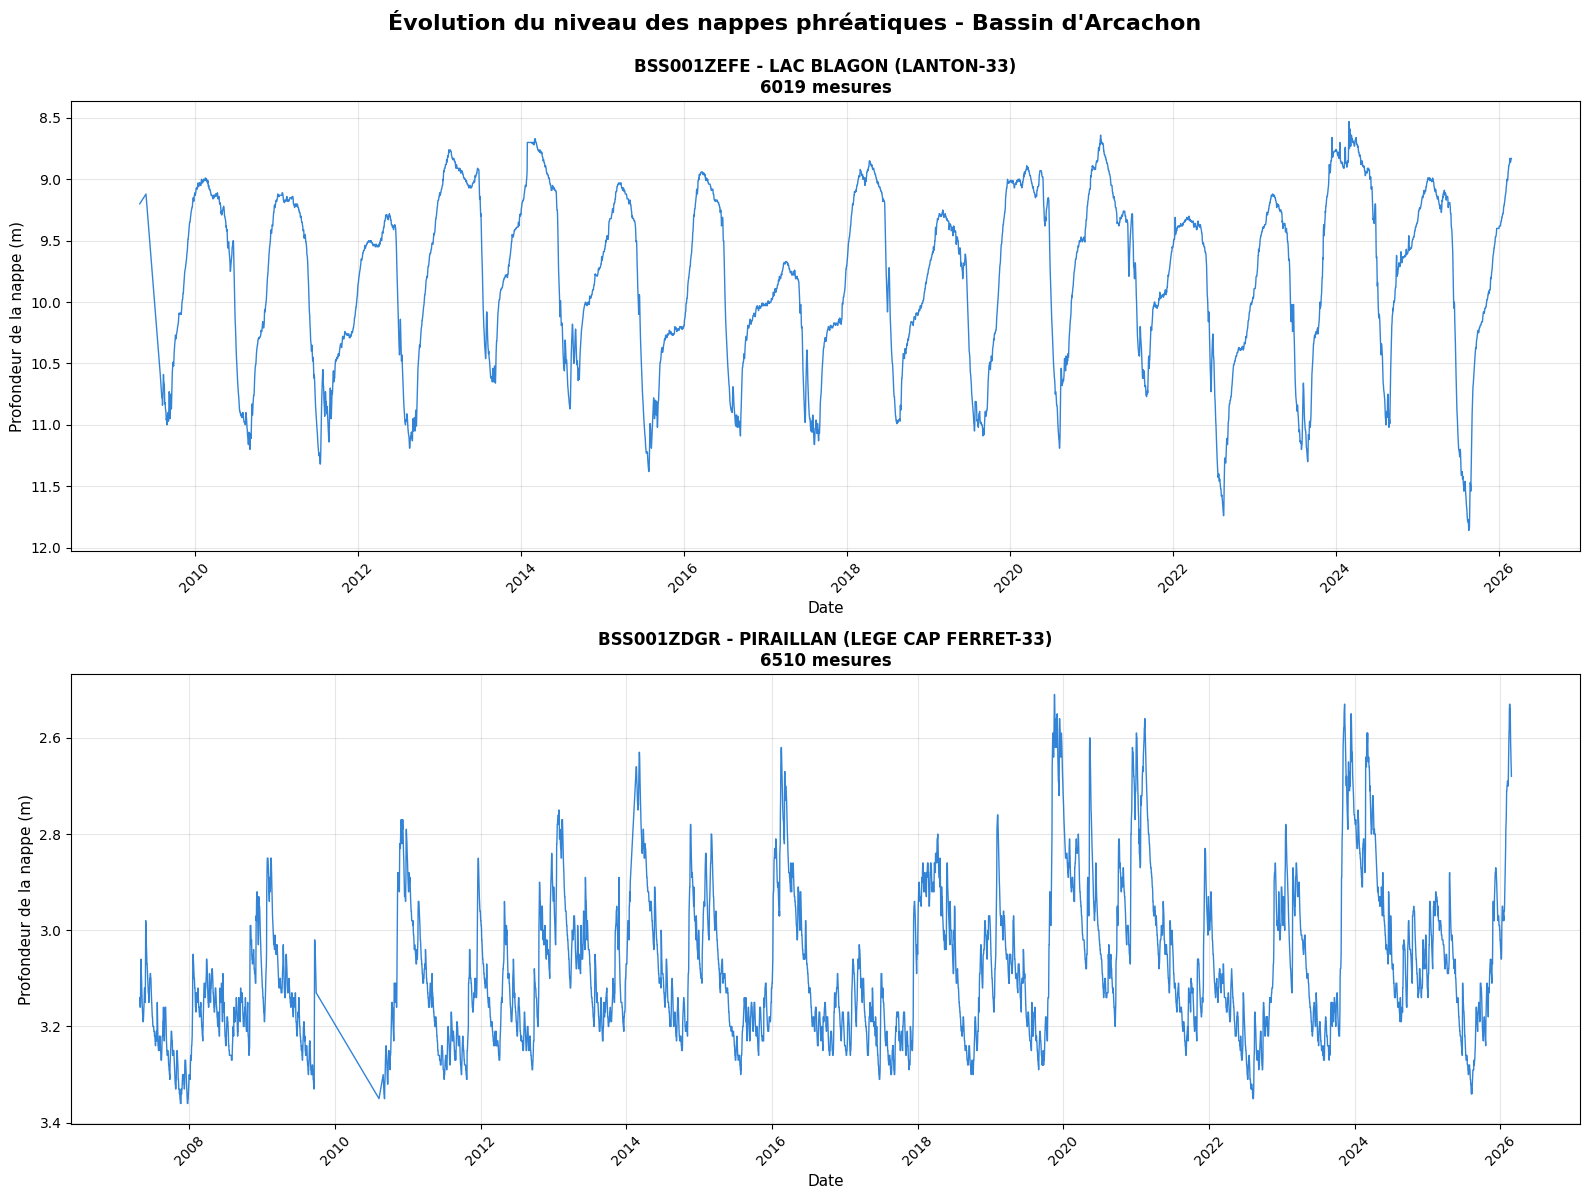


✓ Graphiques générés avec succès!


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time

# Définir les points de mesure
piezometers = [
    {
        'code_bss': '08262X0290/F',
        'name': 'BSS001ZEFE - LAC BLAGON (LANTON-33)',
        'location': 'Lanton'
    },
    {
        'code_bss': '08257X0086/F',
        'name': 'BSS001ZDGR - PIRAILLAN (LEGE CAP FERRET-33)',
        'location': 'Lège-Cap-Ferret'
    }
]

# URL de l'API
url = 'https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/chroniques.json'

# Fonction pour récupérer toutes les données d'un piézomètre
def fetch_piezometer_data(code_bss, name):
    print(f"\n{'='*70}")
    print(f"Récupération des données: {name}")
    print(f"Code BSS: {code_bss}")
    print('='*70)
    
    all_data = []
    page = 1
    size = 1000
    
    while True:
        params = {
            'code_bss': code_bss,
            'size': size,
            'page': page,
            'sort': 'asc'
        }
        
        response = requests.get(url, params=params)
        
        if response.status_code not in [200, 206]:
            print(f"Erreur HTTP {response.status_code}")
            break
        
        data = response.json()
        
        if page == 1:
            total_count = data.get('count', 0)
            print(f"Total de mesures disponibles: {total_count}")
        
        records = data.get('data', [])
        if not records:
            break
        
        all_data.extend(records)
        print(f"Page {page}: +{len(records)} mesures (total: {len(all_data)})")
        
        if data.get('next') is None:
            break
        
        page += 1
        time.sleep(0.1)
    
    print(f"✓ Récupération terminée: {len(all_data)} mesures")
    
    # Créer le DataFrame
    df = pd.DataFrame(all_data)
    if len(df) > 0:
        df['date_mesure'] = pd.to_datetime(df['date_mesure'], errors='coerce')
        df = df.sort_values('date_mesure')
    
    return df

# Récupérer les données pour chaque piézomètre
dataframes = {}
for piezo in piezometers:
    df = fetch_piezometer_data(piezo['code_bss'], piezo['name'])
    dataframes[piezo['code_bss']] = {
        'df': df,
        'name': piezo['name'],
        'location': piezo['location']
    }

# Créer les graphiques
print(f"\n{'='*70}")
print("CRÉATION DES GRAPHIQUES")
print('='*70)

fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Évolution du niveau des nappes phréatiques - Bassin d\'Arcachon', 
             fontsize=16, fontweight='bold', y=0.995)

for idx, (code_bss, data) in enumerate(dataframes.items()):
    df = data['df']
    name = data['name']
    location = data['location']
    
    if len(df) == 0:
        print(f"⚠ Aucune donnée pour {name}")
        continue
    
    # Afficher les statistiques
    print(f"\n{name}")
    print(f"  Période: {df['date_mesure'].min().strftime('%d/%m/%Y')} → {df['date_mesure'].max().strftime('%d/%m/%Y')}")
    print(f"  Durée: {(df['date_mesure'].max() - df['date_mesure'].min()).days} jours")
    print(f"  Profondeur min: {df['profondeur_nappe'].min():.2f} m")
    print(f"  Profondeur max: {df['profondeur_nappe'].max():.2f} m")
    print(f"  Profondeur moyenne: {df['profondeur_nappe'].mean():.2f} m")
    print(f"  Nombre de mesures: {len(df)}")
    
    # Créer le graphique
    ax = axes[idx]
    ax.plot(df['date_mesure'], df['profondeur_nappe'], 
            linewidth=1, color='#0066cc', alpha=0.8)
    
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Profondeur de la nappe (m)', fontsize=11)
    ax.set_title(f'{name}\n{len(df)} mesures', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Inverser l'axe Y (profondeur décroissante = nappe qui monte)
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("✓ Graphiques générés avec succès!")
print('='*70)